In [ ]:
# Core
import numpy as np
import pandas as pd

# Visualization (matplotlib only)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Utils
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving blood.csv to blood.csv


In [ ]:
# Load the dataset
df = pd.read_csv('blood.csv')
display(df.head())
print(df.shape)
df.info()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


(748, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [ ]:
display(Markdown("### Basic Quality Checks"))

# Nulls and duplicates
nulls = df.isna().sum()
dups = df.duplicated().sum()

display(Markdown(f"- **Missing values per column:**\n\n{nulls.to_string()}"))
display(Markdown(f"- **Duplicate rows:** {dups}"))

# Target distribution
class_counts = df['Class'].value_counts().sort_index()
class_ratio = (class_counts / class_counts.sum()).round(3)
display(Markdown("**Target (Class) distribution:**"))
display(pd.DataFrame({'count': class_counts, 'ratio': class_ratio}))


### Basic Quality Checks

- **Missing values per column:**

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0

- **Duplicate rows:** 215

**Target (Class) distribution:**

,count,ratio
Class,,
0,570,0.762
1,178,0.238


## Exploratory Data Analysis

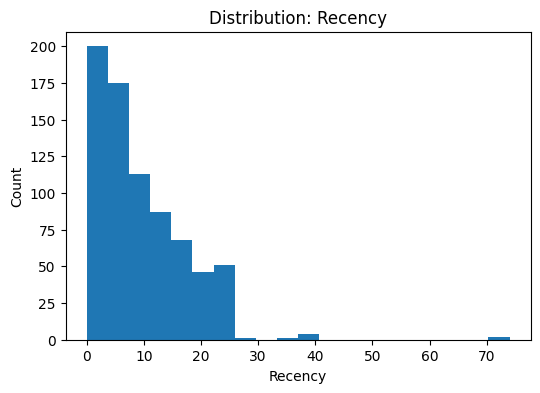

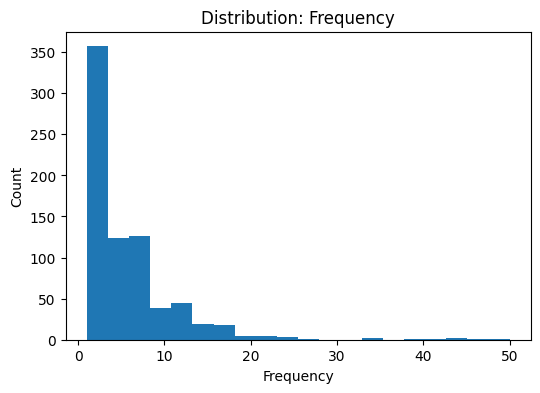

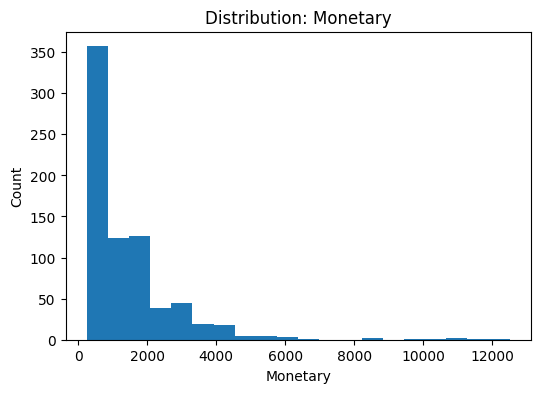

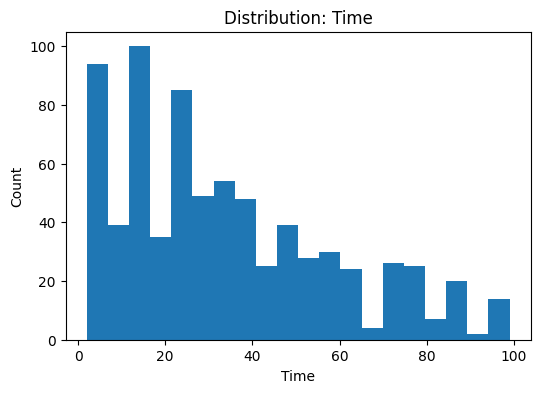

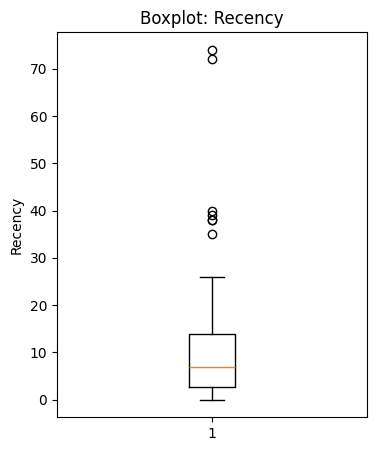

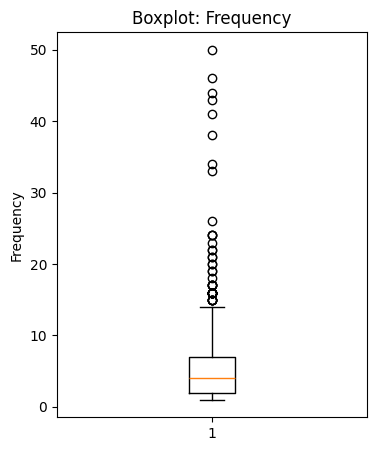

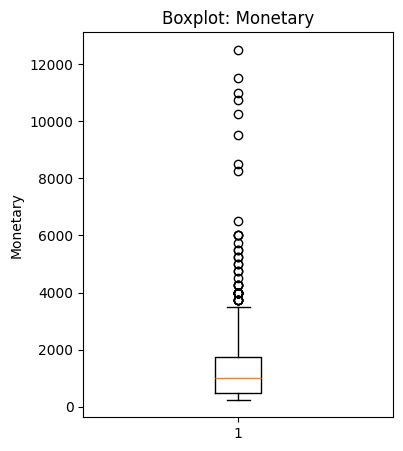

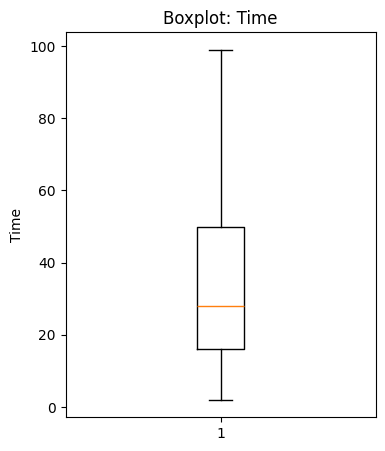

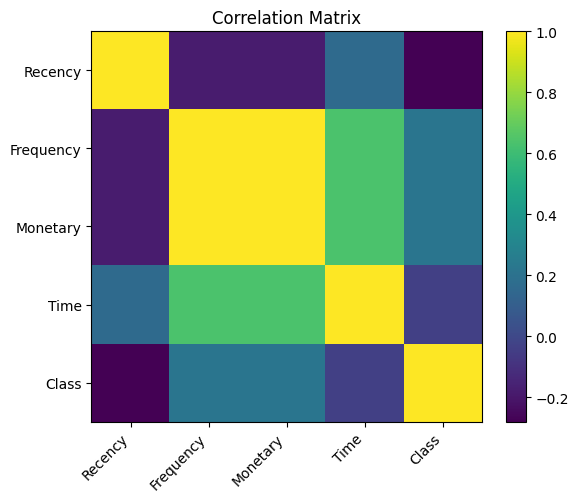

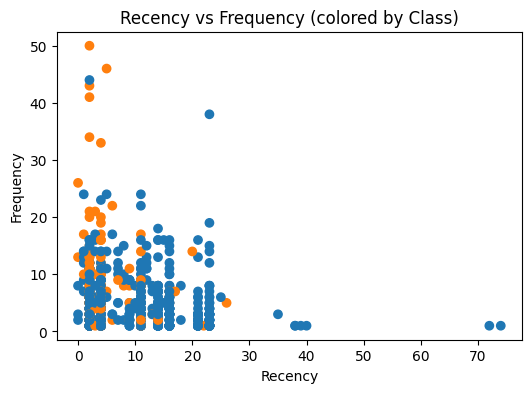

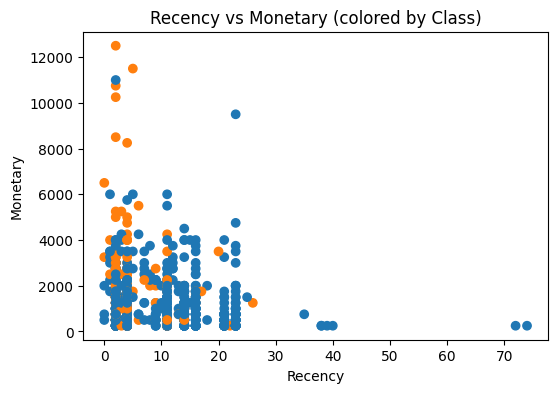

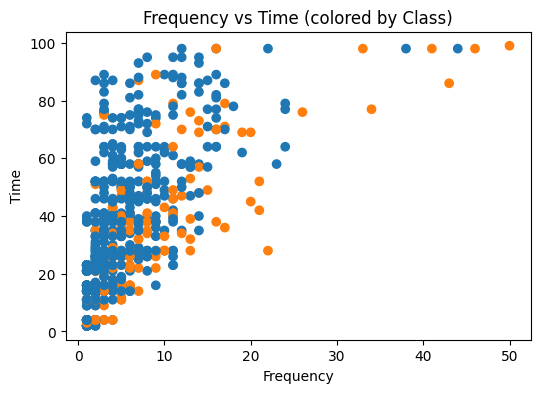

**Feature summary grouped by Class:**

Recency                  Frequency                      Monetary  \
            mean median       std      mean median       std         mean   
Class                                                                       
0      10.771930   11.0  8.425039  4.801754    3.0  4.746768  1200.438596   
1       5.455056    4.0  5.170615  7.803371    6.0  8.043005  1949.438202   

                                 Time                    
       median          std       mean median        std  
Class                                                    
0       750.0  1186.692017  34.770175   28.0  24.605388  
1      1500.0  2009.223005  32.730337   28.0  23.645816

In [ ]:
display(Markdown("## Exploratory Data Analysis"))

num_cols = ['Recency', 'Frequency', 'Monetary', 'Time']
target_col = 'Class'

# Histograms
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=20)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Boxplots
for col in num_cols:
    plt.figure(figsize=(4,5))
    plt.boxplot(df[col], vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()

# Correlation matrix (numerical only)
corr = df[num_cols + [target_col]].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha='right')
plt.yticks(range(corr.shape[0]), corr.index)
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

# Simple scatter relationships colored by Class (0/1)
colors = df[target_col].map({0: 'tab:blue', 1: 'tab:orange'})
pairs = [('Recency','Frequency'), ('Recency','Monetary'), ('Frequency','Time')]
for x, y in pairs:
    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y], c=colors)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{x} vs {y} (colored by Class)")
    plt.show()

# Brief numeric summary by target
summary = df.groupby(target_col)[num_cols].agg(['mean', 'median', 'std'])
display(Markdown("**Feature summary grouped by Class:**"))
display(summary)


In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((598, 4), (150, 4), np.float64(0.23745819397993312), np.float64(0.24))

In [ ]:
display(Markdown("## Baseline Model Comparison (5-fold CV ROC-AUC on training set)"))

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
    ]),
    "RandomForest": Pipeline([
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1,
            class_weight='balanced', random_state=RANDOM_STATE
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE))
    ]),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = []

for name, pipe in models.items():
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_results.append({
        "model": name,
        "cv_auc_mean": np.mean(auc_scores),
        "cv_auc_std": np.std(auc_scores),
    })

cv_df = pd.DataFrame(cv_results).sort_values(by="cv_auc_mean", ascending=False).reset_index(drop=True)
display(cv_df)


## Baseline Model Comparison (5-fold CV ROC-AUC on training set)

,model,cv_auc_mean,cv_auc_std
0,LogisticRegression,0.739984,0.035946
1,SVC,0.730526,0.035634
2,GradientBoosting,0.680857,0.037748
3,RandomForest,0.636166,0.024071


In [ ]:
display(Markdown("## Test Set Performance (default threshold = 0.5)"))

def evaluate_at_threshold(y_true, y_proba, thr=0.5, positive_label=1):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
        "recall": recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "threshold": thr
    }

test_results = []
fitted_models = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    y_proba = pipe.predict_proba(X_test)[:, 1]
    metrics = evaluate_at_threshold(y_test, y_proba, thr=0.5)
    metrics["model"] = name
    test_results.append(metrics)

test_df = pd.DataFrame(test_results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)
display(test_df)

best_model_name = test_df.iloc[0]["model"]
best_model = fitted_models[best_model_name]
display(Markdown(f"**Selected best model:** `{best_model_name}` (by ROC-AUC on test)"))


## Test Set Performance (default threshold = 0.5)

,accuracy,precision,recall,f1,roc_auc,threshold,model
0,0.800000,0.687500,0.305556,0.423077,0.793860,0.5,SVC
1,0.720000,0.454545,0.833333,0.588235,0.784844,0.5,LogisticRegression
2,0.786667,0.590909,0.361111,0.448276,0.739888,0.5,GradientBoosting
3,0.713333,0.414634,0.472222,0.441558,0.712354,0.5,RandomForest


**Selected best model:** `SVC` (by ROC-AUC on test)

## Threshold Tuning (maximize Youden’s J = TPR - FPR)

**Optimal threshold:** 0.319

,accuracy,precision,recall,f1,roc_auc,threshold
0,0.793333,0.555556,0.694444,0.617284,0.79386,0.319157


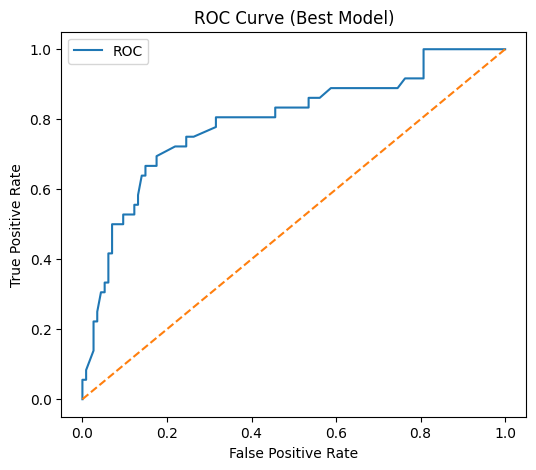

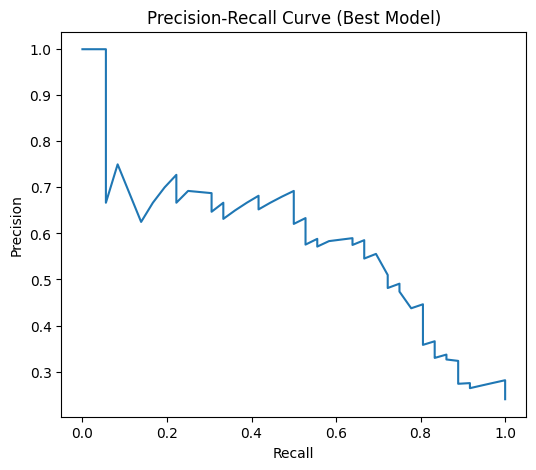

In [ ]:
display(Markdown("## Threshold Tuning (maximize Youden’s J = TPR - FPR)"))

y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_thr = thresholds[best_idx]

tuned_metrics = evaluate_at_threshold(y_test, y_proba_best, thr=best_thr)
display(Markdown(f"**Optimal threshold:** {best_thr:.3f}"))
display(pd.DataFrame([tuned_metrics]))

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Best Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, pr_thr = precision_recall_curve(y_test, y_proba_best)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Best Model)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


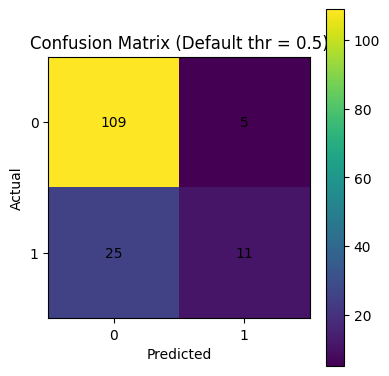

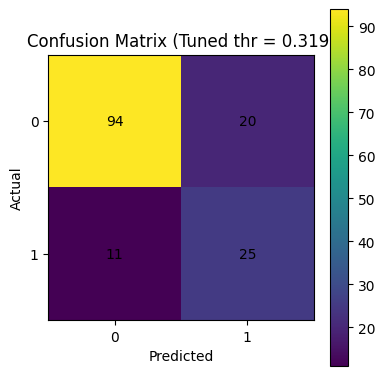

Classification report (tuned threshold):
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       114
           1       0.56      0.69      0.62        36

    accuracy                           0.79       150
   macro avg       0.73      0.76      0.74       150
weighted avg       0.81      0.79      0.80       150



In [ ]:
def plot_conf_mat(y_true, y_proba, thr, title):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_conf_mat(y_test, y_proba_best, thr=0.5, title="Confusion Matrix (Default thr = 0.5)")
plot_conf_mat(y_test, y_proba_best, thr=best_thr, title=f"Confusion Matrix (Tuned thr = {best_thr:.3f})")

print("Classification report (tuned threshold):")
print(classification_report(y_test, (y_proba_best >= best_thr).astype(int), zero_division=0))


In [ ]:
display(Markdown("## Feature Importance / Coefficients"))

feature_names = X.columns.tolist()

if best_model_name == "RandomForest":
    rf = best_model.named_steps['clf'] if 'clf' in best_model.named_steps else best_model
    importances = rf.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    display(fi)
    plt.figure(figsize=(6,4))
    plt.bar(fi["feature"], fi["importance"])
    plt.title("RandomForest Feature Importances")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

elif best_model_name == "GradientBoosting":
    gb = best_model.named_steps['clf'] if 'clf' in best_model.named_steps else best_model
    importances = gb.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    display(fi)
    plt.figure(figsize=(6,4))
    plt.bar(fi["feature"], fi["importance"])
    plt.title("GradientBoosting Feature Importances")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

elif best_model_name == "LogisticRegression":
    # Extract coefficients after scaling
    lr = best_model.named_steps['clf']
    scaler = best_model.named_steps['scaler']
    coefs = lr.coef_.flatten()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)
    display(coef_df)
    plt.figure(figsize=(6,4))
    plt.bar(coef_df["feature"], coef_df["coef"])
    plt.title("Logistic Regression Coefficients")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

elif best_model_name == "SVC":
    display(Markdown("_SVC with RBF kernel is not inherently interpretable via feature importances._"))
else:
    display(Markdown("_No supported importance for this model._"))


## Feature Importance / Coefficients

_SVC with RBF kernel is not inherently interpretable via feature importances._

In [ ]:
display(Markdown("## Donor Segmentation & Recommendations"))

def donor_segment(row):
    # Simple rules: tweak as needed
    if row['Recency'] <= 2 and row['Frequency'] >= 10:
        return "Active-Regular"
    if row['Recency'] <= 3 and row['Frequency'] >= 5:
        return "Active"
    if row['Recency'] <= 6:
        return "Warm"
    if row['Recency'] <= 12:
        return "Lapsed"
    return "Dormant"

def generate_recommendation(prob, segment):
    # prob = predicted probability of future donation
    if prob >= 0.70:
        return "High likelihood — send thank-you + schedule next appointment"
    if prob >= 0.50:
        return "Moderate likelihood — reminder with easy booking link"
    if prob >= 0.30:
        return "Low-moderate — re-engagement campaign + emphasize impact"
    return "Low — low-priority nurture sequence"

# Apply to test set
test_with_scores = X_test.copy()
test_with_scores['proba'] = y_proba_best
test_with_scores['segment'] = test_with_scores.apply(donor_segment, axis=1)
test_with_scores['recommendation'] = [
    generate_recommendation(p, s) for p, s in zip(test_with_scores['proba'], test_with_scores['segment'])
]

display(test_with_scores.head(10))


## Donor Segmentation & Recommendations

,Recency,Frequency,Monetary,Time,proba,segment,recommendation
514,4,16,4000,38,0.517718,Warm,Moderate likelihood — reminder with easy booki...
417,16,1,250,16,0.101115,Dormant,Low — low-priority nurture sequence
497,38,1,250,38,0.113804,Dormant,Low — low-priority nurture sequence
91,4,2,500,4,0.335707,Warm,Low-moderate — re-engagement campaign + emphas...
312,12,9,2250,60,0.153561,Lapsed,Low — low-priority nurture sequence
5,4,4,1000,4,0.466506,Warm,Low-moderate — re-engagement campaign + emphas...
337,11,7,1750,64,0.141636,Lapsed,Low — low-priority nurture sequence
177,4,5,1250,33,0.372979,Warm,Low-moderate — re-engagement campaign + emphas...
468,22,1,250,22,0.110023,Dormant,Low — low-priority nurture sequence
249,11,2,500,11,0.160903,Lapsed,Low — low-priority nurture sequence


In [ ]:
import joblib

model_artifact = f"best_model_{best_model_name}.joblib"
joblib.dump(best_model, model_artifact)
print(f"Saved: {model_artifact}")

# Example: predict for a new donor
example = pd.DataFrame([{
    "Recency": 2,
    "Frequency": 12,
    "Monetary": 3000,
    "Time": 48
}])
pred_prob = best_model.predict_proba(example)[:,1][0]
print(f"Predicted probability of future donation: {pred_prob:.3f}")


Saved: best_model_SVC.joblib
Predicted probability of future donation: 0.468


## Business Impact

- The model can help a blood bank **rank donors by probability** of donating again.
- Pair the probability with **segment-driven messaging** to improve conversions:
  - Active-Regular → express gratitude & auto-schedule
  - Warm → quick reminder + easy booking link
  - Lapsed → personalized re-engagement (impact stories, incentives)
  - Dormant → low-priority nurture
